#Advanced Machine Learning

Master's Degree in Data Science (A.Y. 2021/2022)

Assignment 4

Nome: Silvia Cognome: Ranieri \ Matricola: 878067

The task of the assignment #4 is Transfer Learning using a CNN pretrained on IMAGENET.

The suggested architecture is the VGG16.

The CNN should be used as fixed feature extractor on a new task of your choice containing a number of classes in the range from 2 to 10. 

The report must contain:
- a description of the new task and on the dataset used
- the use of the pretrained CNN as feature extractor considering different layers (at least 3 different choices)
- the chosen "classical" classifier
- for each transfer learning experiment:

the details about the chosen layer
the plot of the classification performance on train/val/test for the different layers considered
the hyper-parameters used for training the "classical" classifier

#Task

Task: Classificazione delle immagini il dataset che ho scelto per svolgere questo compito è CIFAR-10 composto da 60000 immagini a colori 32x32 in 10 classi, con 6000 immagini per classe.

Train: 50000 immagini e test: 10000. 

Ho scelto di tenere solo 5 categorie.


In [1]:
import numpy as np
import keras
from keras.models import Model
from keras.datasets.cifar10 import load_data
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.vgg16 import preprocess_input 
from keras.models import Sequential
from keras.layers import Flatten, MaxPool2D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn import datasets, svm, metrics

Come fase di prepocessamento ho utilizzato l'addestramento di VGG di keras: 

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()

train_index = np.where(y_train.ravel() >= 5)
test_index = np.where(y_test.ravel() >= 5)

x_train = x_train[train_index]
y_train = y_train[train_index]
x_test = x_test[test_index]
y_test = y_test[test_index]

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)
img_shape = x_train[0].shape

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
print("train shape: ", x_train.shape)
print("test shape: ", x_test.shape)
print("train target shape: ", y_train.shape)
print("test target shape: ", y_test.shape)

train shape:  (25000, 32, 32, 3)
test shape:  (5000, 32, 32, 3)
train target shape:  (25000, 1)
test target shape:  (5000, 1)


#Primo taglio 

Come suggerito ho utilizzato  l'architettura VGG19, sviluppata da Karen Simonyan e Andrew Zisserman nel 2014. È un'architettura convnet semplice e ampiamente utilizzata per ImageNet.

Ho passato 4 argomenti al costruttore:

**pesi**: specifica il punto di controllo del peso da cui inizializzare il modello.

**include_top **: si riferisce all'inclusione (o meno) del classificatore densamente connesso in cima alla rete. Per impostazione predefinita, questo classificatore densamente connesso corrisponde alle 1.000 classi di ImageNet. Poiché intendo utilizzare il mio classificatore densamente connesso, non è necessario includerlo.

**input_shape:** tupla di forma opzionale

**classi:** numero opzionale di classi in cui classificare le immagini, da specificare solo se include_top è True e se non viene specificato alcun argomento weights.


Il primo taglio consiste in un modo semplice per tagliare strati completamente convolutivi di VGG16. In questo caso ci sono 14.714.688 parametri apprendibili.
Dopo questo passaggio è necessario estrarre le caratteristiche dal livello block5pool e aggiungere uno strato appiattito. 

In [4]:
model_VGG16 = VGG16(weights='imagenet', input_shape=img_shape, include_top=False) 
model_VGG16 .summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [5]:
output = model_VGG16.get_layer('block5_pool').output
output = Flatten()(output)
model = Model(model_VGG16.input, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [6]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('block5_pool').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(25000, 1, 1, 512)
(5000, 1, 1, 512)


In [7]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Scelgo la classificazione vettoriale di supporto lineare per l'esperimento, considerando 3 diversi livelli. Viene fatto uno split train 80% e 20% test.
Successivamente viene addestrato la SVC con parametro C (ovvero parametro di regolarizzazione) uguale a 0.1 e max_iterazione uguale a 1000, con funzione di perdita = squared_hinge.

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.8)

In [9]:
feat_train = model.predict(x_train) 
feat_test= model.predict(x_test) 
print(feat_train.shape)
print(feat_test.shape)

(5000, 512)
(20000, 512)


In [10]:
np.save('x_train_taglio_fc.npy',feat_train)
np.save('x_test_taglio_fc.npy', feat_test)

In [11]:
print("train shape: ", feat_train.shape)
print("test shape: ", feat_test.shape)

train shape:  (5000, 512)
test shape:  (20000, 512)


In [12]:
print("train shape: ", x_train.shape)
print("test shape: ", y_train .shape)

train shape:  (5000, 32, 32, 3)
test shape:  (5000, 1)


In [13]:
lsvc = LinearSVC(verbose=0)
print(lsvc)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

LinearSVC()


LinearSVC(C=0.1)

In [14]:
lsvc.fit(feat_train , y_train)
score = lsvc.score(feat_train , y_train)
print("Score: ", score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score:  0.8992


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Valore accuratezza alto sembra un buon modello.

#Perfromance sul Train

In [15]:
ypred1 = lsvc.predict(feat_train)

cm1 = confusion_matrix(y_train, ypred1)
print(cm1)

[[ 866   43   70   10    4]
 [  85  881    6    0    1]
 [ 128   26  833    5    8]
 [  20    5    4 1006   11]
 [  37    3   17   21  910]]


In [16]:
cr1 = classification_report(y_train, ypred1)
print(cr1)

              precision    recall  f1-score   support

           5       0.76      0.87      0.81       993
           6       0.92      0.91      0.91       973
           7       0.90      0.83      0.86      1000
           8       0.97      0.96      0.96      1046
           9       0.97      0.92      0.95       988

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [17]:
accuracy_train1= accuracy_score(y_train, ypred1)
accuracy_train1

0.8992

# Performance Validation

In [18]:
ypred1 = lsvc.predict(feat_test )

cm1 = confusion_matrix(y_test, ypred1)
print(cm1)

[[2919  375  459  145  109]
 [ 521 3164  155  101   86]
 [ 705  211 2772  137  175]
 [ 224   93  110 3248  279]
 [ 320   76  190  362 3064]]


In [19]:
cr1 = classification_report(y_test, ypred1)
print(cr1)

              precision    recall  f1-score   support

           5       0.62      0.73      0.67      4007
           6       0.81      0.79      0.80      4027
           7       0.75      0.69      0.72      4000
           8       0.81      0.82      0.82      3954
           9       0.83      0.76      0.79      4012

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



In [20]:
accuracy_validation1= accuracy_score(y_test, ypred1)
accuracy_validation1

0.75835

# Performance sul Test

In [21]:
ypred1 = lsvc.predict(feat_test )

cm1 = confusion_matrix(y_test , ypred1)
print(cm1)

[[2919  375  459  145  109]
 [ 521 3164  155  101   86]
 [ 705  211 2772  137  175]
 [ 224   93  110 3248  279]
 [ 320   76  190  362 3064]]


In [22]:
cr1 = classification_report(y_test , ypred1)
print(cr1)

              precision    recall  f1-score   support

           5       0.62      0.73      0.67      4007
           6       0.81      0.79      0.80      4027
           7       0.75      0.69      0.72      4000
           8       0.81      0.82      0.82      3954
           9       0.83      0.76      0.79      4012

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



In [23]:

accuracy_test1= accuracy_score(y_test, ypred1)
accuracy_test1

0.75835

# Secondo taglio

Procedo con un altro taglio al modello VGG16 più vicino all'input verifico se migliora l'accuratezza.
Il livello block4_pool di VGG16.
Il procedimento è simile a quello eseguito precedentemente.


In [24]:
from tensorflow.keras.models import Model
base_model = VGG16(weights = 'imagenet', input_shape=img_shape, include_top=False )
model2 = Model(inputs = model.input, outputs = model.get_layer('block4_pool').output)
output = model2.get_layer('block4_pool').output
output = Flatten()(output)
model2 = Model(model2.input, output)
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [25]:
block4_pool_train_feat = model2.predict(x_train)
block4_pool_test_feat = model2.predict(x_test)

In [26]:

print(block4_pool_train_feat.shape)
print(block4_pool_test_feat.shape)

(5000, 2048)
(20000, 2048)


In [27]:
np.save('x_train_taglio_block4pool.npy', block4_pool_train_feat)
np.save('x_test_taglio_block4pool.npy', block4_pool_test_feat) 

In [28]:
feat_train= np.load('x_train_taglio_block4pool.npy')
feat_test= np.load('x_test_taglio_block4pool.npy')


In [29]:
lsvc = LinearSVC(verbose=0)
print(lsvc)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

LinearSVC()


LinearSVC(C=0.1)

In [30]:
lsvc.fit(feat_train, y_train)
score = lsvc.score(feat_train , y_train)
print("Score: ", score)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# Performance sul train

In [31]:
ypred2 = lsvc.predict(feat_train)

cm2 = confusion_matrix(y_train, ypred2)
print(cm2)

[[ 993    0    0    0    0]
 [   0  973    0    0    0]
 [   0    0 1000    0    0]
 [   0    0    0 1046    0]
 [   0    0    0    0  988]]


In [32]:
cr2 = classification_report(y_train, ypred2)
print(cr2)

              precision    recall  f1-score   support

           5       1.00      1.00      1.00       993
           6       1.00      1.00      1.00       973
           7       1.00      1.00      1.00      1000
           8       1.00      1.00      1.00      1046
           9       1.00      1.00      1.00       988

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



In [33]:
accuracy_train2= accuracy_score(y_train, ypred2)
accuracy_train2

1.0

#Performance sul Validation

In [34]:
ypred2 = lsvc.predict(feat_test )

cm2 = confusion_matrix(y_test, ypred2)
print(cm2)

[[3182  285  410   60   70]
 [ 200 3678   70   42   37]
 [ 309   89 3480   44   78]
 [  44   36   45 3694  135]
 [  58   49  104  157 3644]]


In [35]:
cr2 = classification_report(y_test, ypred2)
print(cr2)

              precision    recall  f1-score   support

           5       0.84      0.79      0.82      4007
           6       0.89      0.91      0.90      4027
           7       0.85      0.87      0.86      4000
           8       0.92      0.93      0.93      3954
           9       0.92      0.91      0.91      4012

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



In [36]:
accuracy_validation2= accuracy_score(y_test, ypred2)
accuracy_validation2

0.8839

#Performance sul Test

In [37]:
ypred2 = lsvc.predict(feat_test )

cm2 = confusion_matrix(y_test, ypred2)
print(cm2)

[[3182  285  410   60   70]
 [ 200 3678   70   42   37]
 [ 309   89 3480   44   78]
 [  44   36   45 3694  135]
 [  58   49  104  157 3644]]


In [38]:
cr2 = classification_report(y_test, ypred2)
print(cr2)

              precision    recall  f1-score   support

           5       0.84      0.79      0.82      4007
           6       0.89      0.91      0.90      4027
           7       0.85      0.87      0.86      4000
           8       0.92      0.93      0.93      3954
           9       0.92      0.91      0.91      4012

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



In [39]:
accuracy_test2= accuracy_score(y_test, ypred2)
accuracy_test2

0.8839

Rispetto al modello precedente notiamo che questo sia migliore.

#Terzo taglio

Procedo con un ulteriore taglio e valuto le performance del modello. Questo vicino all'input rispetto al precedente, viene eseguito dopo il layer block3_pool di VGG16.


In [40]:
from tensorflow.keras.models import Model
base_model = VGG16(weights = 'imagenet', input_shape=img_shape, include_top=False )
model3 = Model(inputs = base_model.input, outputs = base_model.get_layer('block3_pool').output)
output = model3.get_layer('block3_pool').output
output = Flatten()(output)
model3 = Model(model3.input, output)
model3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [41]:
block3_pool_feat_train  = model3.predict(x_train)
block3_pool_feat_test = model3.predict(x_test)
print(block3_pool_feat_train .shape)
print(block3_pool_feat_test.shape)

(5000, 4096)
(20000, 4096)


In [42]:
np.save('x_train_taglio_block3pool.npy', block3_pool_feat_train )
np.save('x_test_taglio_block3pool.npy', block3_pool_feat_test)



In [43]:
feat_train = np.load('x_train_taglio_block3pool.npy')
feat_test = np.load('x_test_taglio_block3pool.npy')



In [44]:
lsvc = LinearSVC(verbose=0)
print(lsvc)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

LinearSVC()


LinearSVC(C=0.1)

In [45]:
lsvc.fit( feat_train, y_train)
score = lsvc.score(feat_train, y_train)
print("Score: ", score)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score:  1.0


#Performance sul train

In [46]:
ypred3 = lsvc.predict(feat_train)

cm3 = confusion_matrix(y_train, ypred3)
print(cm3)

[[ 993    0    0    0    0]
 [   0  973    0    0    0]
 [   0    0 1000    0    0]
 [   0    0    0 1046    0]
 [   0    0    0    0  988]]


In [47]:
cr3 = classification_report(y_train, ypred3)
print(cr3)

              precision    recall  f1-score   support

           5       1.00      1.00      1.00       993
           6       1.00      1.00      1.00       973
           7       1.00      1.00      1.00      1000
           8       1.00      1.00      1.00      1046
           9       1.00      1.00      1.00       988

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



In [48]:
accuracy_train3= accuracy_score(y_train, ypred3)
accuracy_train3

1.0

# Performance sul Validation

In [49]:
ypred3 = lsvc.predict(feat_test)

cm3 = confusion_matrix(y_test , ypred3)
print(cm3)

[[3316  260  313   50   68]
 [ 191 3713   42   48   33]
 [ 348   74 3459   41   78]
 [  37   43   50 3707  117]
 [  55   53   76  164 3664]]


In [50]:
cr3 = classification_report(y_test, ypred3)
print(cr3)

              precision    recall  f1-score   support

           5       0.84      0.83      0.83      4007
           6       0.90      0.92      0.91      4027
           7       0.88      0.86      0.87      4000
           8       0.92      0.94      0.93      3954
           9       0.93      0.91      0.92      4012

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



In [51]:
accuracy_validation3= accuracy_score(y_test, ypred3)
accuracy_validation3

0.89295

#Performance sul test

In [52]:
ypred3 = lsvc.predict(feat_test)

cm3 = confusion_matrix(y_test , ypred3)
print(cm3)

[[3316  260  313   50   68]
 [ 191 3713   42   48   33]
 [ 348   74 3459   41   78]
 [  37   43   50 3707  117]
 [  55   53   76  164 3664]]


In [53]:
cr3 = classification_report(y_test, ypred3)
print(cr3)

              precision    recall  f1-score   support

           5       0.84      0.83      0.83      4007
           6       0.90      0.92      0.91      4027
           7       0.88      0.86      0.87      4000
           8       0.92      0.94      0.93      3954
           9       0.93      0.91      0.92      4012

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



In [54]:
accuracy_test3= accuracy_score(y_test, ypred3)
accuracy_test3

0.89295

Conclusioni: il miglior modello è quello del terzo taglio

#Grafico accuracy Train

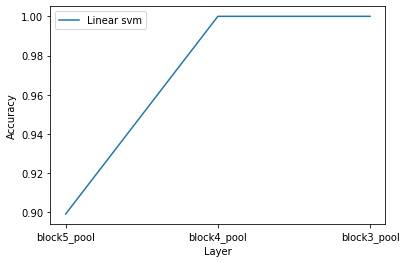

In [55]:
import matplotlib.pyplot as plt
accuracy_train = [accuracy_train1,accuracy_train2,accuracy_train3]

x_plot = list(['block5_pool','block4_pool','block3_pool'])

plt.figure()
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.plot(x_plot, accuracy_train)

plt.legend(['Linear svm'])

#Grafico accuracy Validation

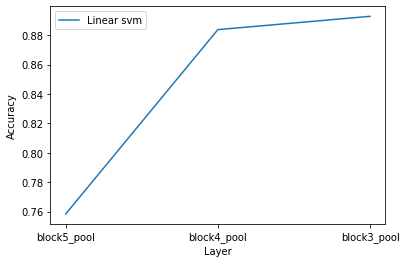

In [56]:


accuracy_val = [accuracy_validation1,accuracy_validation2,accuracy_validation3]

x_plot = list(['block5_pool','block4_pool','block3_pool'])

plt.figure()
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.plot(x_plot, accuracy_val)

plt.legend(['Linear svm'])

#Grafico accuracy Test

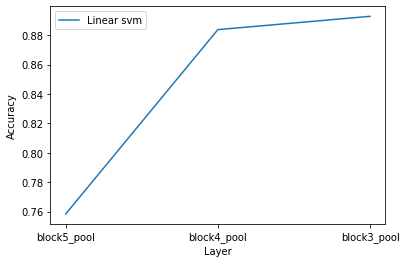

In [57]:


accuracy_test = [accuracy_test1,accuracy_test2,accuracy_test3]

x_plot = list(['block5_pool','block4_pool','block3_pool'])

plt.figure()
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.plot(x_plot, accuracy_test)

plt.legend(['Linear svm'])